In [1]:
# Python libraries
import os
import sys
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
import keras
import matplotlib.pyplot as plt

# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Import custom functions from other notebooks
sys.path.append("myfun/")
from ipynb.fs.full.myfun_nn import *
from ipynb.fs.full.myfun_model_nn import *
from ipynb.fs.full.myfun_model_linlog import *

2024-02-13 11:41:14.794683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 11:41:14.794714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 11:41:14.795533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 11:41:14.801066: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 11:41:15.536001: W tensorflow/compiler/tf2

# Solve the Burger equation

In [2]:
## Params
N = 200
T = 0.5
trange = 0, 0.245, T
rho_l = 0.4
rho_r = 0.8
flux_flag = 0 # Case study

In [3]:
# Intial positions and consecutive distances
## Space
rng = np.random.default_rng(12)
a = rng.uniform(-1, 0, int(N/3))
b = rng.uniform(0, 1, N-int(N/3))

my_rnd = np.concatenate([a, b])

# Check if sorted
if all(my_rnd[i] <= my_rnd[i+1] for i in range(len(my_rnd) - 1)):
    print("All the vehicles are sorted")
    X = m_rnd
else:
    print("There's at least a vehicle not sorted")
    X = my_rnd.copy()
    X.sort()
    
c = [0]*100
xspan = np.concatenate([X,c])

There's at least a vehicle not sorted


In [4]:
xspan

array([-0.99717297, -0.97977128, -0.9356443 , -0.91829671, -0.89314873,
       -0.88492062, -0.86564826, -0.86491214, -0.82975373, -0.82070859,
       -0.81210979, -0.81067962, -0.7986553 , -0.78061007, -0.7777861 ,
       -0.76945875, -0.74917554, -0.74204504, -0.74122891, -0.71735959,
       -0.67610495, -0.65011076, -0.59190153, -0.58310396, -0.58099295,
       -0.56346368, -0.55103662, -0.54638388, -0.53185341, -0.52400287,
       -0.49987615, -0.46391139, -0.45853384, -0.44173466, -0.39988971,
       -0.39971521, -0.38352318, -0.35075963, -0.33836553, -0.32955426,
       -0.32948953, -0.31323989, -0.28854613, -0.27112862, -0.25675002,
       -0.23637491, -0.22115991, -0.2196172 , -0.20702992, -0.199222  ,
       -0.14186951, -0.12844415, -0.11975   , -0.10369063, -0.1018428 ,
       -0.09391613, -0.08547541, -0.07718912, -0.0724833 , -0.06330388,
       -0.05688332, -0.05439932, -0.0533813 , -0.05324706, -0.0530318 ,
       -0.05073388,  0.00272549,  0.00658222,  0.00707994,  0.00

In [5]:
tspan = np.linspace(0,T,160)

In [6]:
# Flux

if flux_flag == 0:

    # Case study
    def f(z):
        return z*(1-z)

    def fprime(z):
        return 1-2*z

    def fprime_inv(z):
        return .5*(1-z)
    
if flux_flag == 1:

    ## Burger
    def f(z):
        return z*z

    def fprime(z):
        return 2*z

    def fprime_inv(z):
        return z/2

In [7]:
# Initial Condition
def rho_bar(x):
    result = 0
    if(x >= -1 and x <= 0):
        result = rho_l
    if(x > 0 and x < 1):
        result = rho_r
    return result

# Solution (rarefaction wave)
def rho(x,t):
    result = 0
    if(x <= fprime(rho_l)*t):
        result = rho_l
    if(x > fprime(rho_l)*t and x <= fprime(rho_r)*t):
        result = fprime_inv(x/t)
    if(x > fprime(rho_r)*t):
        result = rho_r
    return result

In [8]:
# speed of shock
s = (f(rho_r) - f(rho_l))/(rho_r - rho_l)

# shock
def gamma(t):
    return s*t

# Lax-Entropy condition
if fprime(rho_l) < s or fprime(rho_r) > s:
    print("Lax-Entropy condition not satisfied")

In [9]:
s, (f(rho_r),f(rho_l)), (fprime(rho_l), fprime(rho_r))

(-0.20000000000000004,
 (0.15999999999999998, 0.24),
 (0.19999999999999996, -0.6000000000000001))

### Characteristics

In [10]:
## Characteristics

def ispositive(n):
    result = True
    if n < 0:
        result = False
    return result

def characteristic(xspan,tspan):
    
    result = []
    
    for x0 in xspan:
        
        tmp = x0
        char = [x0]
        shock = [gamma(tspan[0])]
        nocross_cond = True
        
        for t in tspan[1:]:
            
            shock.append(gamma(t))
            cond = (tmp <= shock[-1])
            
            if cond:
                tmp = x0 + rho_l*t
            else:
                tmp = x0 + rho_r*t

            if nocross_cond:
                val = (tmp-shock[-1])/(char[-1]-shock[-2])  
                nocross_cond = ispositive(val)
            else:
                #print("nocross_cond is False now")
                tmp = gamma(t)

            char.append(tmp)
            
        result.append(char)

    return result

In [11]:
chars = characteristic(xspan,tspan)
len(chars[0]), len(tspan)

/tmp/ipykernel_4326/490521149.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  val = (tmp-shock[-1])/(char[-1]-shock[-2])


(160, 160)

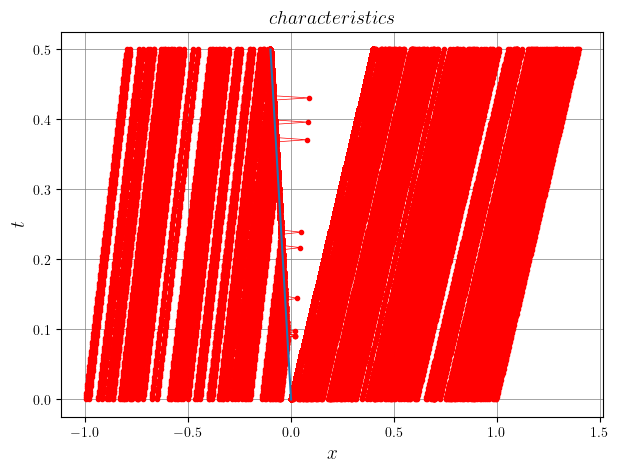

In [12]:
# Initialize the fig
nrow, ncol = 1, 1
width, height = 7, 5 # single subplot
fig, ax = plt.subplots(nrow,ncol,figsize=(width,height))

for ch in chars:
    ax.plot(ch,tspan, c='red', ls='-', lw = 0.5, marker = '.')

ax.plot(gamma(tspan),tspan)

# labeling     
ax.set_xlabel(r"$x$",fontsize=14)
ax.set_ylabel(r"$t$",fontsize=14)
ax.set_title(fr"$characteristics$",fontsize=14)
ax.grid(color='grey', linestyle='-', linewidth=0.5)
    
plt.show()

### Solution

In [13]:
yrange = []

for x in xspan:
    y = []
    for t in trange:
        y.append(rho(x,t))
    yrange.append(y)

In [14]:
tspan_rounded = list(np.round(tspan,3))

idx = [tspan_rounded.index(t) for t in trange]
charrange = [[ch[i] for i in idx] for ch in chars]

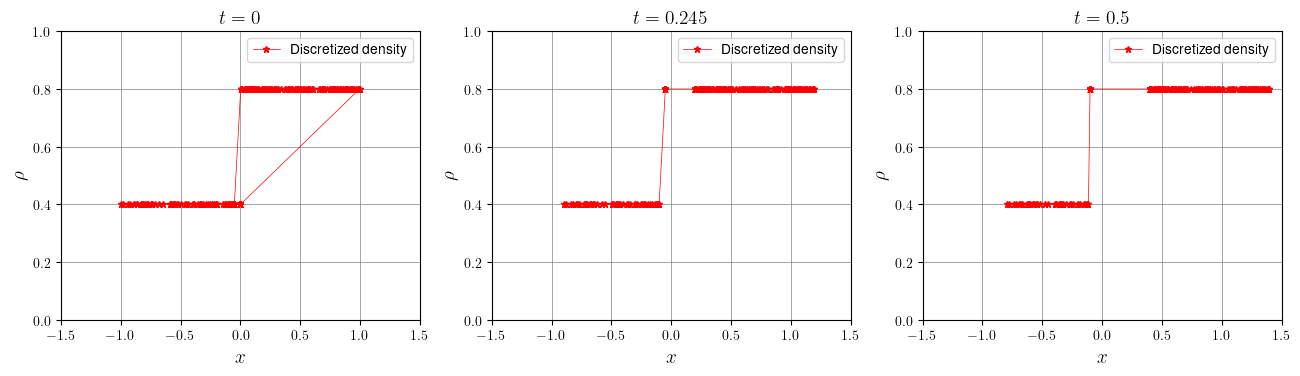

In [15]:
# Initialize the fig
nrow, ncol = 1, 3
width, height = 7, 5 # single subplot
fig, axes = plt.subplots(nrow,ncol,figsize=(width*ncol*.75,height*.75))

for step, (ax, t) in enumerate(zip(axes.ravel(), trange)):
    char, y = [c[step] for c in charrange], [y[step] for y in yrange]
    ax.plot(char,y,c='red', ls='-', lw = 0.5, ms=5, marker='*', label="Discretized density")
    #     ax.plot(char,y*0,c='blue', ls='', ms=5, marker='o', label="Particles")

    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([0, 1])

    # labeling     
    ax.set_xlabel(r"$x$",fontsize=14)
    ax.set_ylabel(r"$\rho$",fontsize=14)
    ax.set_title(fr"$t={t}$",fontsize=14)

    ax.grid(color='grey', linestyle='-', linewidth=0.5)
    ax.legend()
    
plt.show()